In [16]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
import imutils

IMAGE_PATH = 'omr_test.png'
NUM_QUESTIONS = 5
NUM_CHOICES = 5
# Define the correct answers with key value pairs
# Eg: Question 1 (index 0) -> Answer B (index 1)
#     Question 2 (index 1) -> Answer E (index 4)
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}


STEP 1: Edge Detection


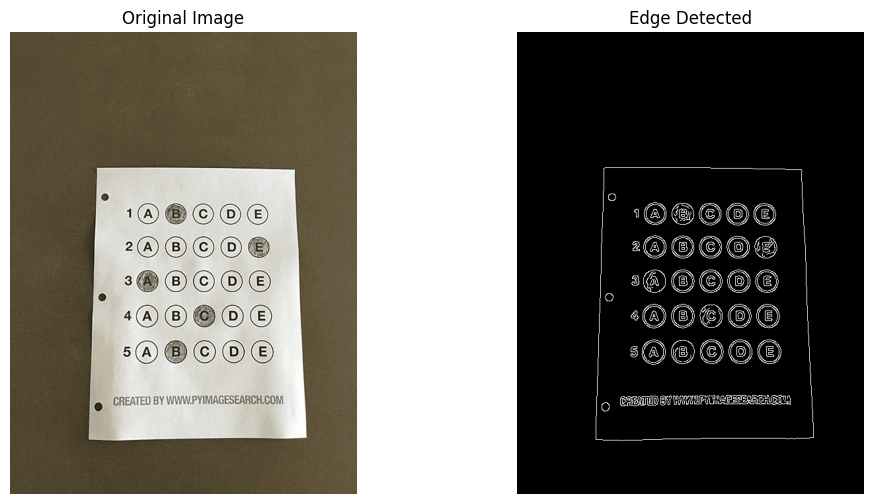

In [17]:
# Loading the image
image = cv2.imread(IMAGE_PATH) #The variable image now holds the entire image as a NumPy array
original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # To display the original img

# Pre-processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converts to gray-scale; only the shaded part in the omr is necessary for us
blurred = cv2.GaussianBlur(gray, (5, 5), 0) # bluring to remove noise; eg:paper texture, spec of dust which gives false edges
edged = cv2.Canny(blurred, 75, 200) # edge detection, sees where there is sudden increase in pixels (here 75 to 200)to give us the egde(Canny- edge algo)

print("STEP 1: Edge Detection")

# Visualize the results
plt.figure(figsize=(12, 6)) 

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Edge Detected")
plt.imshow(edged, cmap='gray')
plt.axis('off')

plt.show()

STEP 2: Found Document Outline
[[[131 206]]

 [[119 617]]

 [[448 614]]

 [[430 208]]]


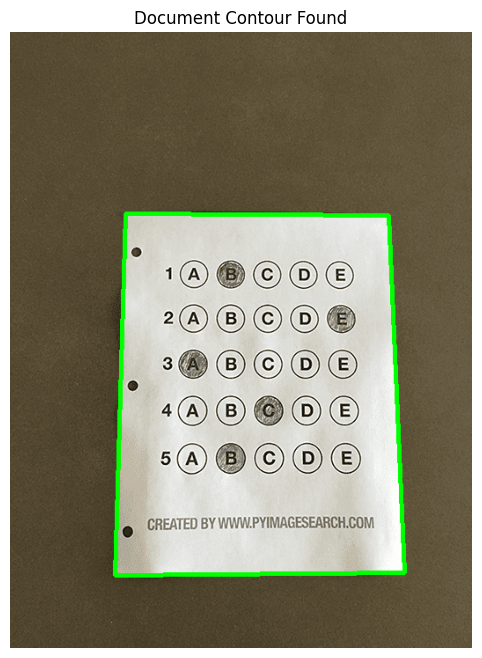

In [18]:
# Find the contours in the edge-detected image
contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
doc_contour = None

# Ensure at least one contour was found
if len(contours) > 0:
    # Sort the contours by area and take the largest one(reverse = True)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Loop over sorted contours to find one with 4 points
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # If our approximated contour has four points, we can assume it's the document
        if len(approx) == 4:
            doc_contour = approx
            break

if doc_contour is None:
    raise Exception("Could not find the document outline. Make sure all four corners are visible.")

print("STEP 2: Found Document Outline")
print(doc_contour)

# Visualize the result
image_with_contour = image.copy()
cv2.drawContours(image_with_contour, [doc_contour], -1, (0, 255, 0), 3)
image_with_contour_rgb = cv2.cvtColor(image_with_contour, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.title("Document Contour Found")
plt.imshow(image_with_contour_rgb)
plt.axis('off')
plt.show()

STEP 3: Applied Perspective Transform (using native OpenCV)


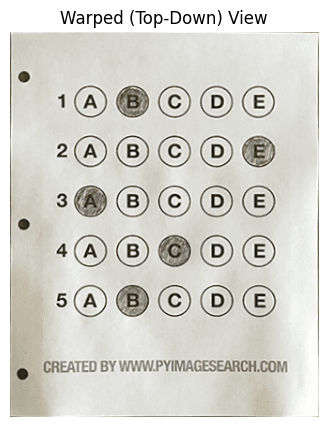

In [19]:
# The Robust OpenCV Way to do a Four-Point Perspective Transform

# 1. Order the corner points of the document contour
pts = doc_contour.reshape(4, 2)
rect = np.zeros((4, 2), dtype="float32")
s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]
(tl, tr, br, bl) = rect

# 2. Compute the width and height of the new, warped image
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

# 3. Define the destination points for our "bird's-eye view"
dst = np.array([
	[0, 0],
	[maxWidth - 1, 0],
	[maxWidth - 1, maxHeight - 1],
	[0, maxHeight - 1]], dtype="float32")

# 4. Compute the perspective transform matrix and apply it
M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))


# --- The rest of the cell remains the same ---
warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

print("STEP 3: Applied Perspective Transform (using native OpenCV)")

# --- Visualize the result ---
plt.figure(figsize=(10, 5))
plt.title("Warped (Top-Down) View")
plt.imshow(warped_rgb)
plt.axis('off')
plt.show()

STEP 4: Applied Threshold to Isolate Bubbles


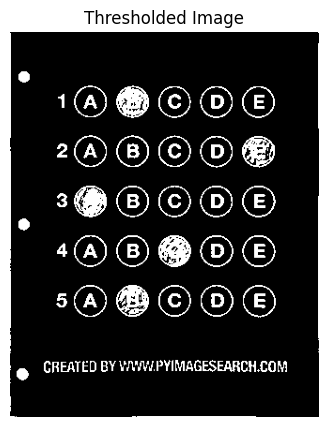

In [24]:
# Binarize the warped image using Otsu's thresholding method
thresh = cv2.threshold(warped_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

print("STEP 4: Applied Threshold to Isolate Bubbles")

# --- Visualize the thresholded image ---
plt.figure(figsize=(10, 5))
plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Step 5: Find, Sort, and Grade the Bubbles

# Find contours in the thresholded image, these will be the bubbles
# We use RETR_EXTERNAL again to find the outer shape of each white blob.
bubble_contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bubble_contours = imutils.grab_contours(bubble_contours)

# Filter contours to keep only the ones that are likely bubbles
question_contours = []
for c in bubble_contours:
    (x, y, w, h) = cv2.boundingRect(c)
    aspect_ratio = w / float(h)
    
    # Check if the contour is roughly circular and of a reasonable size
    # You may need to tweak these values for your specific OMR sheet design
    if w >= 20 and h >= 20 and 0.9 <= aspect_ratio <= 1.1:
        question_contours.append(c)

print(f"STEP 5: Filtered contours. Found {len(question_contours)} bubbles. Expected {NUM_QUESTIONS * NUM_CHOICES}.")

# Now, sort the question contours from top to bottom. This groups them by question row.
# We'll use a simple lambda function to sort based on the y-coordinate of the bounding box.
question_contours = sorted(question_contours, key=lambda c: cv2.boundingRect(c)[1])

score = 0
# Create a copy of the original warped image to draw our results on
output_image = warped.copy()

# The Main Grading Loop
# Iterate over the questions in chunks of NUM_CHOICES (e.g., 5 at a time)
for q_index in range(0, len(question_contours), NUM_CHOICES):
    
    # Get the contours for the current question's row
    # Then, sort these 5 contours from left-to-right based on their x-coordinate.
    current_question_contours = sorted(question_contours[q_index:q_index + NUM_CHOICES], key=lambda c: cv2.boundingRect(c)[0])
    
    bubbled = None # This will store the answer the user picked for this question
    
    # Loop through the 5 sorted bubbles for the current question
    for b_index, c in enumerate(current_question_contours):
        # Create a black mask to isolate just the current bubble
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1) # -1 fills the bubble shape
        
        # Apply the mask to our thresholded image. This "cuts out" the bubble region.
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        
        # Count the number of white pixels in the bubble region
        total_pixels = cv2.countNonZero(mask)
        
        # If this bubble has more white pixels than the one we've seen so far,
        # it's the new most likely candidate for the selected answer.
        if bubbled is None or total_pixels > bubbled[0]:
            bubbled = (total_pixels, b_index)
            
    # Visualize and Score 
    color = (0, 0, 255) # Default color is RED (incorrect)
    correct_answer_index = ANSWER_KEY[q_index // NUM_CHOICES]
    
    # Check if the detected answer (bubbled[1]) is correct
    if correct_answer_index == bubbled[1]:
        color = (0, 255, 0) # If it's correct, change color to GREEN
        score += 1
        
    # Draw a colored circle around the TRUE correct answer bubble
    cv2.drawContours(output_image, [current_question_contours[correct_answer_index]], -1, color, 3)

print("Grading logic complete. The results are drawn on the output image.")

STEP 5: Filtered contours. Found 25 bubbles. Expected 25.
Grading logic complete. The results are drawn on the output image.


FINAL SCORE: Score: 80.00% (4/5)


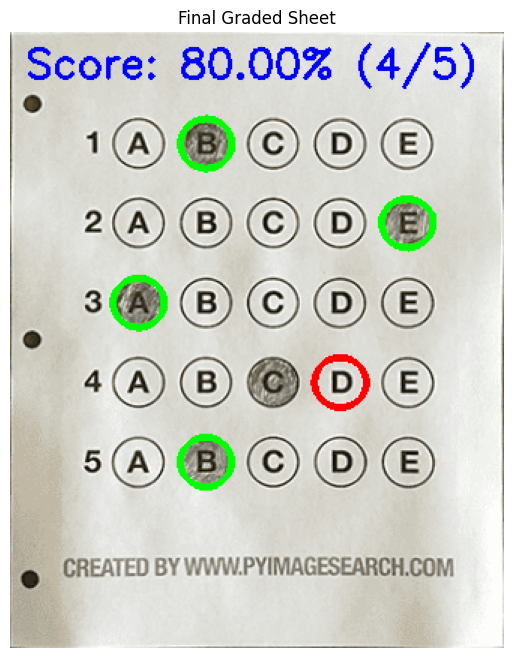

In [22]:
# Calculate and display the final score
score_percent = (score / NUM_QUESTIONS) * 100
score_text = f"Score: {score_percent:.2f}% ({score}/{NUM_QUESTIONS})"
cv2.putText(output_image, score_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

print(f"FINAL SCORE: {score_text}")

# --- Visualize the final graded sheet ---
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title("Final Graded Sheet")
plt.imshow(output_image_rgb)
plt.axis('off')
plt.show()